### Overview of the patent assignees/owners belonging to academia for each disease

#### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import string

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_normalized_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN


In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_normalized_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN


Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 9), (76321, 9))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 9)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 9)

### Historic perspective of academic vs industry assignees

Patent document based assignee ranking 

In [10]:
UNIVERSITY_ASSIGNEES = {
    'National Yang Ming Chiao Tung University',
    'KYOTO University',
    'Jacobs University',
    'The Scripps Research Institute',
    'Goethe University Frankfurt',
    'Northwestern University',
    'Helmholtz Zentrum Munchen - German Research Center for Environmental Health',
    'Atilim University',
    'Vanderbilt University',
    'University of Siena',
    'North Carolina Central University',
    'Hanyang University',
    'Portland State University',
    'University of Oslo',
    'National Taiwan Normal University',
    'University of Strasbourg',
    'University of Oviedo',
    'Yonsei University Industry Academic Cooperation Foundation',
    'Virginia Commonwealth University',
    'University of Georgia',
    'University of Tennessee Research Foundation',
    'University of Copenhagen',
    'McGill University',
    'Ludwig Maximilian University of Munich',
    'University of Allahabad',
    'Laval University',
    'Boston University',
    'Osaka University',
    'Institute of Molecular Biotechnology of the OeAW',
    'University of Barcelona',
    'Helmholtz Centre for Infection Research',
    'National Institute of Biological Sciences',
    'Medical Center of Postgraduate Education',
    'Sagami Chemical Research Institute (SCRI)',
    'University Health Network',
    'Oregon State University',
    'University of California',
    'University of Louisville Research Foundation',
    'Tianjin Institute of Pharmaceutical Research',
    'The University of Edinburgh',
    'Saarland University',
    'University of Liege',
    'Palacky University Olomouc',
    'Leiden University',
    'The University of British Columbia',
    'University of Arizona',
    'Dana-Farber Cancer Institute',
    'University of Warsaw',
    'Indiana University Research And Technology Corporation',
    'Jagiellonian University',
    'Aix-Marseille University',
    'University Technologies International Inc',
    'Heart Institute',
    'Sapienza University of Rome',
    'University of Montreal',
    'Willamette University',
    'University of Rochester',
    'University of Southern California (USC) Stevens Center for Innovation',
    'Northeastern University',
    'University of North Carolina',
    'University of Massachusetts',
    'New York University',
    'KU Leuven',
    'Keimyung University',
    'Salk Institute for Biological Studies',
    'Kitasato Institute',
    'Helmholtz Zentrum Munchen',
    'The Hong Kong Polytechnic University',
    'Paris Descartes University',
    'University of Konstanz',
    'Ohio University',
    'Josep Carreras Leukaemia Research Institute',
    'Alexander Fleming Biomedical Sciences Research Center',
    'Marquette University',
    'Lieber Institute for Brain Development (LIBD)',
    'Tel Aviv University',
    'Istanbul University',
    'The City University of New York',
    'Pasteur Institute',
    'University of Aberdeen',
    'University of Kansas',
    'Thomas Jefferson University',
    'Montana State University',
    'University of Nebraska-Lincoln',
    'North Carolina State University',
    'Columbia University',
    'Andres Bello National University',
    'Ariel University',
    'UNIVERSITY KING ABDULAZIZ',
    'Jinan University',
    'University of Nantes',
    'University of Milano',
    'University of Bristol',
    'Hefei Institutes of Physical Science',
    'Institute for Hepatitis and virus research',
    'ETH Zurich',
    'University of Illinois Urbana-Champaign',
    'Korea Research Institute of Chemical Technology',
    'Georgia State University Research Foundation',
    'Flemish Institute for Biotechnology',
    'Bandeirante University of Sao Paulo',
    'UCB',
    'Middle Tennessee State University',
    'Florida Agricultural and Mechanical University',
    'Yale University',
    'The University of Toronto Governing Council',
    'Chosun University Industry-Academia Cooperation',
    'California Institute of Technology',
    'Massachusetts Institute of Technology',
    'Institute of Molecular Medicine (iMM)',
    'Sichuan University',
    'University of Texas',
    'Shenyang Pharmaceutical University',
    'University of Miami',
    'The University of Maryland',
    'University of Florida Research Foundation',
    'Cornell University',
    'Hungarian Academy of Sciences',
    'University College Cardiff Consultants Ltd',
    'Cardiff University',
    'Emory University',
    'Parker Hughes Institute',
    'University of Dayton',
    'University of Dundee',
    'Harvard College',
    'University of London',
    'Clemson University',
    'French National Institute of Health and Medical Research (Inserm)',
    'Texas Tech University System',
    'University of Southampton',
    'Indiana University Board of Trustees',
    'Sanford Burnham Prebys Medical Discovery Institute',
    'Ohio State University',
    'University of Greenwich',
    'University of Mississippi',
    'Brandeis University',
    'Saint Louis University',
    'Icahn School of Medicine at Mount Sinai',
    'Drexel University',
    'Shanghai Institute of Materia Medica',
    'National Health Research Institutes (NHRI)',
    'Erasmus University Medical Center',
    'Baruch S. Blumberg Institute',
    'University of the Basque Country',
    'Monash University',
    'Heart Research Institute',
    'University of Montana',
    'Zhejiang University',
    'Aarhus University',
    'Duquesne University',
    'Massey University',
    'Albert Einstein College of Medicine',
    'Medical University of Warsaw',
    'University City',
    'University of Chicago',
    'Northwest University',
    'University of Pittsburgh',
    'University of Innsbruck',
    'Lille 2 University of Health and Law',
    "Xi'an Jiaotong University",
    'Taipei Medical University',
    'University of Oregon',
    'University of Leeds',
    'Trustees of Boston College',
    'Korea University Research and Business Foundation',
    'University of Notre Dame',
    'Regents of The University of Michigan',
    'INRAE',
    'University of Arkansas',
    'University of Kentucky Research Foundation',
    'University of Milan',
    'University of South Carolina',
    'University of Toyama',
    'The Kitasato Institute',
    'Chemical Institute of Sarria',
    'University of Florence',
    'Iowa State University Research Foundation',
    'Sanford Burnham Prebys',
    'University of Colorado Boulder',
    'Duke University',
    'Gladstone Institutes',
    'Simon Fraser University',
    'City University of Hong Kong',
    'Howard University',
    'University of Rouen Normandy',
    'Huazhong University of Science and Technology',
    'Yantai University',
    'Johns Hopkins University',
    'Oslo University Hospital',
    'Catalan Institution for Research and Advanced Studies (ICREA)',
    'Chinese Academy of Medical Sciences',
    'Seattle Childrens Research Institute',
    'The Trustees Of Columbia University',
    'University of Saskatchewan',
    'The University of Tokyo',
    'University of Texas System',
    'University of Nottingham',
    'University of Bath',
    'Ewha University-Industry Collaboration Foundation',
    'Case Western Reserve University',
    'Zucker Institute for Innovation Commercialization',
    'PSL Research University',
    'University of Colorado Board of Regents',
    'University of Michigan',
    'Shandong University',
    'Korea Institute of Science and Technology',
    'Parkinsons Institute',
    'Whitehead Institute',
    'University of Alberta',
    'Shanghai institute of Organic Chemistry',
    'University of Florida',
    'The University of Virginia',
    'University of Oxford',
    'North Dakota State University Research Foundation',
    'Institute for One World Health',
    'Imam Abdulrahman Bin Faisal University',
    'Institute of Advanced Technology and Research and Development,',
    'East China University of Science and Technology',
    'Georgetown University',
    'Washington University in St. Louis',
    'University of Windsor',
    'Arizona State University',
    'University of Pennsylvania',
    'University of North Carolina at Chapel Hill at Chapel Hill',
    'Indian Institute Of Technology',
    'The Rockefeller University',
    'University-industry Cooperation Group of Kyung Hee University',
    'Oxford University Innovation',
    'National Institutes for Quantum Science and Technology (QST)',
    'Nankai University',
    'Temple University',
    'Yamaguchi University',
    'Rutgers University',
    'The Translational Genomics Research Institute (TGen)',
    'Illinois Board of Trustees',
    'Institute of Biochemistry and Biophysics',
    'Buck Institute for Research on Aging',
    'Wake Forest University',
    'University of Limerick',
    'University of North Carolina at Greensboro',
    'University of Utah',
    'University of Minnesota',
    'University of Connecticut',
    'University of Melbourne',
    'University of Vienna',
    'Walter and Eliza Hall Institute of Medical Research',
    'Gunma University',
    'Institute of Botany of the Czech Academy of Sciences',
    'National University of Singapore',
    'University of Lille',
    'China Central Research Academy,',
    'Keio University',
    'Peking University',
    'Georgia Tech Research Institute',
    'University of Antwerp',
    'University of Kentucky',
    'Shanghai Institute of Materia Medica Chinese Academy of Sciences',
    'University of Zurich',
    'The Institute of Cancer Research',
    'Schepens Eye Research Institute',
    'Broad Institute',
    'University of Toronto',
    'Institute for Research in Biomedicine',
    'Chiba University',
    'University of Milano-Bicocca',
    'University of North Carolina at Chapel Hill',
    'STC University of New Mexico',
    'Stanford University',
    'Allegheny College',
    'The Netherlands Cancer Institute',
    'Nagoya University',
    'The University of Oklahoma',
    'Regents of the University of California',
    'King Abdulaziz University',
    'Hannover Medical School',
    'Wistar Institute',
    'University of Birmingham',
    'Pusan National University',
    'Italian Institute of Technology',
    'Guangzhou Institute of Biomedicine and Health',
    'Fudan University',
    'Research Foundation of State University of New York',
    'Kyung Hee University-Industry Cooperation',
    'University of Iowa Research Foundation',
    'Grande ABC University',
    'University of Eastern Piedmont',
    'Ottawa Hospital Research Institute',
    'Mie University',
    'The University of New Mexico',
    'University of Leicester',
    'Kaohsiung Medical University',
    'Autonomous University of Barcelona',
    'Claude Bernard University Lyon 1',
    'Brown University',
    'University College Cork',
    'Soochow University',
    'University of Southern California',
    'National Institute of Advanced Industrial Science and technology (AIST)',
    'Dr. Wolff Group',
    'Mangosuthu University of Technology',
    'University of Washington',
    'Muroran Institute of Technology',
    'Human BioMolecular Research Institute',
    'Tulane University',
    'Wayne State University',
    'National University Corporation Kyushu University',
    'IMDEA Food Institute',
    'University of Helsinki',
    'Korea Research Institute of Bioscience & BioTechnology',
    'University of Cape Town',
    'Technical University of Denmark',
    'Sao Paulo Research Foundation',
    'University of Queensland',
    'McMaster University',
    'University of Illinois',
}

In [11]:
def create_assignee_rank(df: pd.DataFrame):
    """Create assignee dataframe based on the no.of patent documents contributed."""
    
    patent_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, assignee, org, is_aquired, person_name in tqdm(
        df[['patent_id', 'date', 'assignee', 'organization_name', 'acquired_by', 'person']].values
    ):
        year = date.split("-")[0]
        
        if pd.notna(is_aquired) or pd.notna(person_name):  # Skip non organisation
            continue
        
        if org in UNIVERSITY_ASSIGNEES:
            patent_dict['university'][year].add(patent_idx)
        else:
            patent_dict['industy'][year].add(patent_idx)
        
        
    patent_data = []
    for assignee_type, year_based_dict in patent_dict.items():
        # Get total patent count
        all_patents = set()
        for patents in year_based_dict.values():
            all_patents.update(patents)
        
        for year, year_patents in year_based_dict.items():
            patent_data.append({
                'assignee_type': assignee_type,
                'total_patent_count': len(all_patents),
                'year': int(year),
                'annual_patent_count': len(year_patents)
            })
        
    return pd.DataFrame(patent_data)

In [12]:
rare_disease_assignee_rank = create_assignee_rank(rare_disease_data)
rare_disease_assignee_rank.sort_values(
    by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
rare_disease_assignee_rank.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 335100.73it/s]


,assignee_type,total_patent_count,year,annual_patent_count
19,industy,317,2000,6


In [13]:
alzheimers_disease_assignee_rank = create_assignee_rank(alzheimer_disease_data)
alzheimers_disease_assignee_rank.sort_values(
     by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
alzheimers_disease_assignee_rank.head(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 358300.50it/s]


,assignee_type,total_patent_count,year,annual_patent_count
33,industy,8622,2000,143


### Visualize data

In [14]:
def create_barplot(df1: pd.DataFrame, df2: pd.DataFrame):
    sns.set(style='white')
    
    plt.figure(figsize=(10, 5))
    
    plt.subplots_adjust(wspace=0)
    
    plt.subplot(2,1,1)
    plt.bar(
        df1['year'], df1['annual_patent_count'],
        width=0.5, alpha=0.6, color='#8a853b'
    )
    
    plt.xlabel('Year', size=12)
    plt.ylabel('Number of patents', size=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 45)
    
    plt.title(
        'Patenting landscape within organisations', 
        horizontalalignment='center', size=14,
        verticalalignment='center', weight='bold',
        pad=30
    )
    
    k = df1[['year', 'annual_patent_count']].groupby('year').sum().reset_index()
    plt.plot(k['year'], k['annual_patent_count'], marker='.', color='black', ms=5)

    plt.text(0, 1.1, string.ascii_uppercase[0],  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    
    """Subplot 2"""
    plt.subplot(2,1,2)
    plt.bar(
        df2['year'], df2['annual_patent_count'],
        width=0.5, alpha=0.6
    )

    plt.xlabel('Year', size=12)
    plt.ylabel('Number of patents', size=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    m = df2[['year', 'annual_patent_count']].groupby('year').sum().reset_index()
    plt.plot(m['year'], m['annual_patent_count'], marker='.', color='black', ms=5)
    
    plt.text(0, 1.1, string.ascii_uppercase[1],  
        size=15, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    
    plt.tight_layout()
    
    plt.savefig(
        f'{FIG_DIR}/supplementary_figure_2.png',
        dpi=400,
        bbox_inches='tight', 
    )

    plt.show()

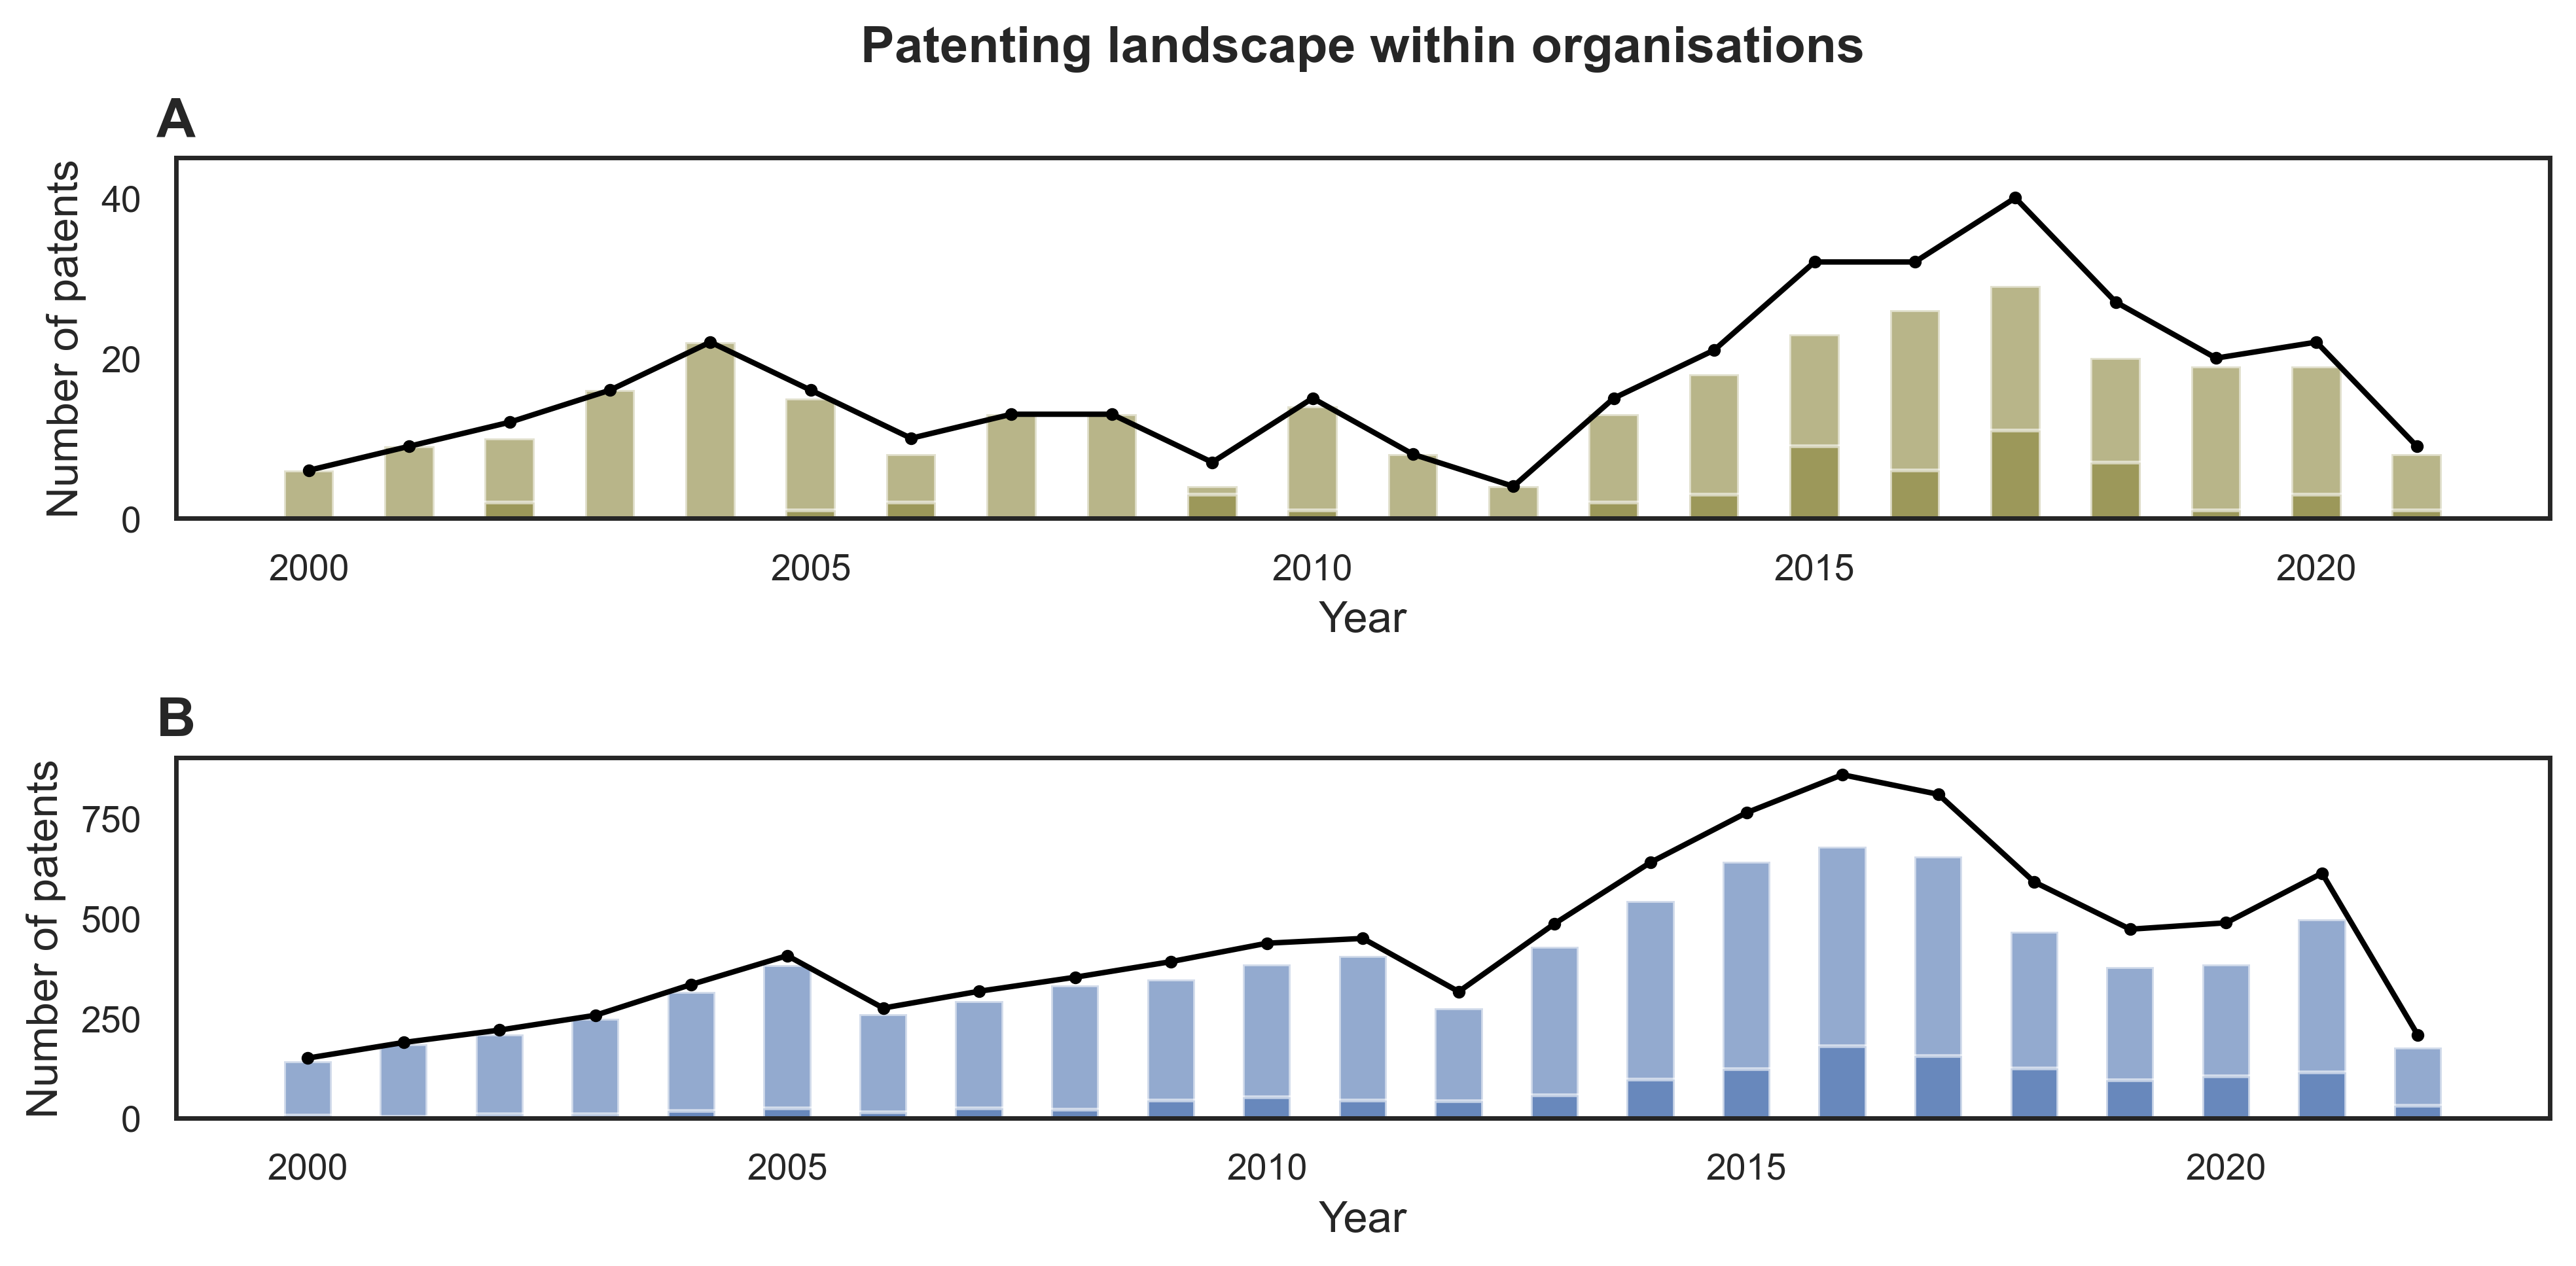

In [15]:
create_barplot(rare_disease_assignee_rank, alzheimers_disease_assignee_rank)